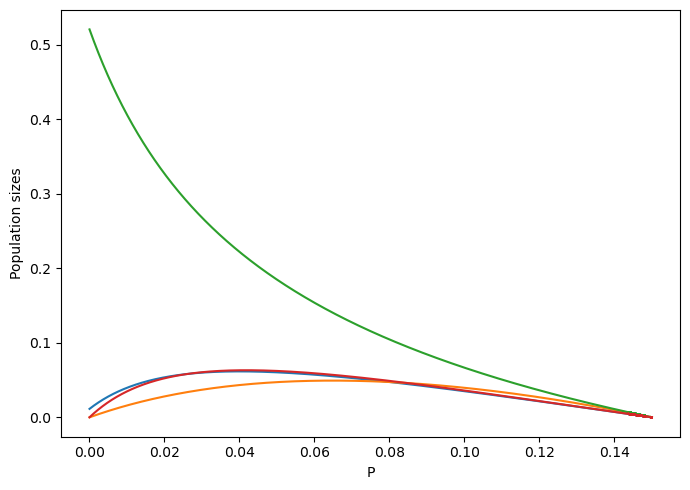

In [227]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize

# Parameters
rho1, rho2, rho3, rho4 = 0.1, 1e-4, 1e-4, 1e-4
alpha1, alpha2, alpha3 = 0.4, 0.5, 0.1
delta2 = 1e-2
beta1, beta2, beta3 = 0.4, 0.2, 0.3
gamma, nu = 1e-1, 0.4
CC, A = 0.887, 0.1

def f_fixedP(y, P):
    B1, B2, B3, B4 = y
    BA = B1 + B2 + B3 + B4
    dB1 = rho1*B1*(1-BA/CC)      - alpha1*A*B1      - beta1*P*B1
    dB2 = rho3*B2*(1-BA/CC) + beta1*P*B1 - (alpha2+alpha3)*A*B2 \
           + beta2*P*B3 - gamma*(P/(1+P))*B2
    dB3 = rho2*B3*(1-BA/CC) + (alpha1*A*B1 + alpha2*A*B2) \
           - (beta2+beta3)*P*B3 - delta2*(A/(1+A))*B3
    dB4 = rho4*B4*(1-BA/CC) + alpha3*A*B2 + beta3*P*B3 \
           - nu*((P+A)/(1+P+A))*B4
    return np.array([dB1, dB2, dB3, dB4])

def jac_fixedP(y, P):
    B1, B2, B3, B4 = y
    BA = B1 + B2 + B3 + B4
    J = np.zeros((4,4))
    # d(dB1)/dB*
    J[0,0] = rho1*(1-BA/CC) - rho1*B1/CC - alpha1*A - beta1*P
    J[0,1:] = -rho1*B1/CC
    # d(dB2)/dB*
    J[1,0] = beta1*P
    J[1,1] = rho3*(1-BA/CC) - rho3*B2/CC - (alpha2+alpha3)*A - gamma*(P/(1+P))
    J[1,2] = beta2*P
    J[1,3] = -rho3*B2/CC
    J[1,:] -= np.array([0, rho3*B2/CC, rho3*B2/CC, rho3*B2/CC])  # the off‐diag density‐dependence
    # d(dB3)/dB*
    J[2,0] = alpha1*A
    J[2,1] = alpha2*A
    J[2,2] = rho2*(1-BA/CC) - rho2*B3/CC - (beta2+beta3)*P - delta2*(A/(1+A))
    J[2,3] = -rho2*B3/CC
    # d(dB4)/dB*
    J[3,1] = alpha3*A
    J[3,2] = beta3*P
    J[3,3] = rho4*(1-BA/CC) - rho4*B4/CC - nu*((P+A)/(1+P+A))
    J[3,0] = J[3,1]*0 - rho4*B4/CC  # same off‐diag CC
    J[3,:] -= np.array([rho4*B4/CC]*4)
    return J

# Precompute starting guess
S = CC*(1 - (alpha1*A/rho1))
x2 = (alpha1*A*S) / (delta2*(A/(1+A)) + alpha1*A*(1-(rho2/rho1)))
x1 = S - x2
y_guess = np.array([x1, 1e-5, x2, 1e-5])

# Continuation sweep
P_vals = np.linspace(1e-5, 0.15, 30000)
B_lists = [[], [], [], []]

for i, P in enumerate(P_vals):
    try:
        sol = optimize.root(
            fun=lambda y: f_fixedP(y, P),
            x0=y_guess,
            jac=lambda y: jac_fixedP(y, P),
            method='hybr',
            tol=1e-12
        )
    except np.linalg.LinAlgError:
        print(f"ERROR: bad Jacobian at i={i}, P={P:.5f}")
        sol = None

    if sol is not None and sol.success:
        y_sol = sol.x
        # check residual
        res = np.linalg.norm(sol.fun)
        if res > 1e-8:
            print(f"WARNING: large residual {res:.2e} at P={P:.5f}")
        # record & update
        for k in range(4):
            B_lists[k].append(y_sol[k])
        y_guess = y_sol
    else:
        print(f"WARNING: root did not converge at i={i}, P={P:.5f}")
        for k in range(4):
            B_lists[k].append(np.nan)
        # keep old guess

# Plot
plt.figure(figsize=(7,5))
labels = ['B1','B2','B3','B4']
for k, lab in enumerate(labels):
    plt.plot(P_vals, B_lists[k], label=lab)
plt.xlabel('P')
plt.ylabel('Population sizes')
#plt.legend()
plt.tight_layout()
plt.savefig('continuation_coexistence.pdf')
plt.show()


[1.88782604e-33 1.17025817e-02 2.03373826e-03 1.59573647e-03]
[-1.98781248e-19  1.17654865e-05 -2.94157417e-05  1.76452059e-05]
[-1.10651845e-27  1.17309104e-05 -2.93427835e-05  1.75732468e-05]
[-1.46943273e-27  1.16964498e-05 -2.92700761e-05  1.75015726e-05]
[-1.65051258e-28  1.16621042e-05 -2.91976184e-05  1.74301819e-05]
[-2.19004649e-28  1.16278732e-05 -2.91254093e-05  1.73590735e-05]
[ 1.69410693e-27  1.15937561e-05 -2.90534477e-05  1.72882462e-05]
[-7.55835856e-28  1.15597525e-05 -2.89817326e-05  1.72176987e-05]
[-2.19506244e-27  1.15258620e-05 -2.89102628e-05  1.71474298e-05]
[-2.94324307e-28  1.14920839e-05 -2.88390374e-05  1.70774382e-05]
[-1.04766013e-27  1.14584179e-05 -2.87680553e-05  1.70077227e-05]
[-1.12675561e-27  1.14248635e-05 -2.86973155e-05  1.69382822e-05]
[-5.30091486e-28  1.13914201e-05 -2.86268168e-05  1.68691154e-05]
[ 1.60903750e-28  1.13580873e-05 -2.85565584e-05  1.68002211e-05]
[ 3.88437665e-27  1.13248646e-05 -2.84865391e-05  1.67315981e-05]
[ 5.67861150e-

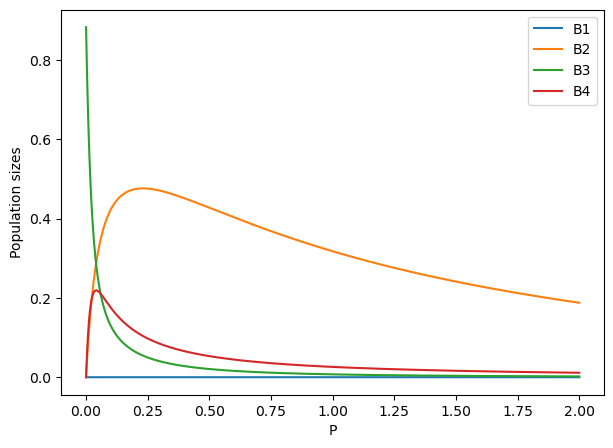

In [231]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize


rho1 = 0.1
rho2 = 1e-1
rho3 = 1e-1
rho4 = 1e-1

alpha1 = 0.1
alpha2 = 0.2
alpha3 = 0.1
delta2 = 1e-2

beta1 = 0.4
beta2 = 0.2
beta3 = 0.3
gamma = 1e-1
nu = 0.4

CC = 0.887
A = 0.05
burstsize = 180
# Assume all your parameters and A, CC, etc. are already defined before

def f_fixedP(y, P_fixed):
    B1, B2, B3, B4 = y
    BA = B1 + B2 + B3 + B4

    dB1 = rho1 * B1 * (1 - BA / CC) - alpha1 * A * B1 - beta1 * P_fixed * B1
    dB2 = rho3 * B2 * (1 - BA / CC) + beta1 * P_fixed * B1 - alpha2 * A * B2 + beta2 * P_fixed * B3 - gamma * (P_fixed / (1 + P_fixed)) * B2 - alpha3 * A * B2
    dB3 = rho2 * B3 * (1 - BA / CC) + alpha1 * A * B1 + alpha2 * A * B2 - beta2 * P_fixed * B3 - beta3 * P_fixed * B3 - delta2 * (A / (1 + A)) * B3
    dB4 = rho4 * B4 * (1 - BA / CC) + alpha3 * A * B2 + beta3 * P_fixed * B3 - nu * ((P_fixed + A) / (1 + P_fixed + A)) * B4

#    dB1 = max(dB1, 0)
#    dB2 = max(dB2, 0)
#    dB3 = max(dB3, 0)
#    dB4 = max(dB4, 0)
    return np.array([dB1, dB2, dB3, dB4])

def jacobian_fixedP(y, P_fixed):
    B1, B2, B3, B4 = y
    BA = B1 + B2 + B3 + B4

    J = np.zeros((4, 4))  # 4x4 Jacobian because P is fixed

    # Partial derivatives for dB1
    J[0, 0] = rho1 * (1 - BA / CC) - rho1 * B1 / CC - alpha1 * A - beta1 * P_fixed
    J[0, 1] = -rho1 * B1 / CC
    J[0, 2] = -rho1 * B1 / CC
    J[0, 3] = -rho1 * B1 / CC

    # Partial derivatives for dB2
    J[1, 0] = beta1 * P_fixed - rho3 * B2 / CC
    J[1, 1] = rho3 * (1 - BA / CC) - rho3 * B2 / CC - alpha2 * A - alpha3 * A - gamma * (P_fixed / (1 + P_fixed))
    J[1, 2] = beta2 * P_fixed - rho3 * B2 / CC
    J[1, 3] = -rho3 * B2 / CC

    # Partial derivatives for dB3
    J[2, 0] = alpha1 * A - rho2 * B3 / CC
    J[2, 1] = alpha2 * A - rho2 * B3 / CC
    J[2, 2] = rho2 * (1 - BA / CC) - rho2 * B3 / CC - beta2 * P_fixed - beta3 * P_fixed - delta2 * (A / (1 + A))
    J[2, 3] = -rho2 * B3 / CC

    # Partial derivatives for dB4
    J[3, 0] = -rho4 * B4 / CC
    J[3, 1] = alpha3 * A - rho4 * B4 / CC
    J[3, 2] = beta3 * P_fixed - rho4 * B4 / CC
    J[3, 3] = rho4 * (1 - BA / CC) - rho4 * B4 / CC - nu * ((P_fixed + A) / (1 + P_fixed + A))

    return J

# CONTINUATION
P_vals = np.linspace(1e-5, 2, 30000)  # Pe axis
B1_list = []
B2_list = []
B3_list = []
B4_list = []

B_A = CC * ((-delta2 / rho2) * (A / (1 + A)) + 1)
# Initial guess
y_guess = [1e-5, 1e-5, B_A, 1e-5]

for i, P_fixed in enumerate(P_vals):
    func = lambda y: f_fixedP(y, P_fixed)
    jac = lambda y: jacobian_fixedP(y, P_fixed)
   # Evaluate Jacobian at current guess
    try:
        J_eval = jac(y_guess)  # evaluate Jacobian at current y_guess
        if np.abs(np.linalg.det(J_eval)) < 1e-13:
            print(f"WARNING: Jacobian is near singular at step {i}, P = {P_fixed:.5f}")
    except np.linalg.LinAlgError:
        print(f"ERROR: Jacobian not invertible at step {i}, P = {P_fixed:.5f}")
    sol = optimize.root(func, y_guess, jac=jac, tol=1e-12)
    print(func(y_sol))

    if sol.success:
        y_sol = sol.x
        B1_list.append(y_sol[0])
        B2_list.append(y_sol[1])
        B3_list.append(y_sol[2])
        B4_list.append(y_sol[3])
        y_guess = y_sol  # Update guess for next step
    else:
        print(f"WARNING: Newton did not converge at step {i}, P = {P_fixed:.5f}")
        B1_list.append(np.nan)
        B2_list.append(np.nan)
        B3_list.append(np.nan)
        B4_list.append(np.nan)
        # Keep old guess

# PLOTTING
plt.figure(figsize=(7,5))
plt.plot(P_vals, B1_list, label='B1')
plt.plot(P_vals, B2_list, label='B2')
plt.plot(P_vals, B3_list, label='B3')
plt.plot(P_vals, B4_list, label='B4')
plt.xlabel('P')
plt.ylabel('Population sizes')
#plt.savefig('res_free.pdf')
plt.legend()
plt.show()